In [1]:
import sys, os, time
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# from foundation import util, models, train
from argparse import Namespace

In [2]:
args = Namespace()

args.dim = 300
args.device = 'cuda:0'

args.batch_size = 1024
args.num_workers = 4

args.loss_type = 'mse'

In [3]:
class Embedding(Dataset):
    def __init__(self, path='../../fast_table.pth.tar'):
        super().__init__()
        
        data = torch.load(path)
        
        self.tuples = data['rows']
        self.table = dict(zip(data['elements'], data['vecs']))
        
    def convert(self, word):
        return torch.from_numpy(self.table[word])
        
    def __len__(self):
        return len(self.tuples)
    
    def __getitem__(self, idx):
        x = torch.cat([self.convert(w) for w in self.tuples[idx]],-1)
        
        return x

In [4]:
dataset = Embedding()
len(dataset)
#traindata, valdata = train.split_dataset(dataset,shuffle=True, split1=1-args.val_per)
#len(traindata), len(valdata)

282594

In [5]:
# trainloader, valloader = DataLoader(traindata, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True), \
#                         DataLoader(valdata, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
# len(trainloader), len(valloader)
dataloader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
len(dataloader)

276

In [6]:
k = 10 # keep lowest distances

In [7]:
path = '../../oie_table.pth.tar'
testset = Embedding(path)
len(testset)

3793

In [8]:
testloader = DataLoader(testset, num_workers=0, batch_size=256, shuffle=False)
len(testloader)

15

In [9]:
def cosd(x,y):
    if x.ndimension() == 1:
        x = x.unsqueeze(0)
    if y.ndimension() == 1:
        y = y.unsqueeze(0)
    x = F.normalize(x, 2, -1)
    y = F.normalize(y, 2, -1)
    return -x @ y.transpose(-1,-2)/2+.5
def l2(x,y):
    if x.ndimension() == 1:
        x = x.unsqueeze(0)
    if y.ndimension() == 1:
        y = y.unsqueeze(0)
    x = x.unsqueeze(-2)
    y = y.unsqueeze(-3)
    return (x-y).pow(2).mean(-1)



In [10]:
class Aggregator(nn.Module):
    def __init__(self, criterion='mean', k=10, largest=True):
        super().__init__()
        
        self.crit = criterion
        
        self.k = k
        self.largest = largest
        
        self.reset()
        
    def reset(self):
        self.best = None
        self.N = 0
        
    def forward(self, cands):
        
        N = cands.size(-1)
        
        if self.crit in {'top', 'extrema'} and self.best is not None:
            cands = torch.cat([self.best,cands],-1)
            
        if self.crit == 'top':
            self.best = cands.topk(self.k, dim=-1, largest=self.largest)[0]
            
        elif self.crit == 'mean':
            
            cands = cands.sum(-1,keepdim=True)
            
            if self.best is not None:
                self.best += cands
            else:
                self.best = cands
                
            self.N += N
            
    def get_result(self):
        
        assert self.best is not None
        
        best = self.best
        
        if self.crit == 'mean':
            best = self.best / self.N
            
        return best
            
        
    

In [11]:
dist_fn = cosd

In [13]:
A = Aggregator('top', k=10, largest=False)
# A = Aggregator('mean')

In [17]:
outs = []
xloader = iter(testloader)
for i,x in tqdm(enumerate(xloader), total=len(xloader)):
    
    A.reset()
    
    yloader = iter(dataloader)
    
    for y in yloader:
        
        dist = dist_fn(x,y)
        
        A(dist)
        
    outs.append(A.get_result())
    
#     print('{}/{} : {} {}'.format(i+1,len(xloader), len(outs), outs[-1].shape))
outs = torch.cat(outs, 0)
outs.shape

A Jupyter Widget

torch.Size([3793, 10])

In [18]:
losses = outs.mean(-1)

In [19]:
# torch.save(losses, 'oie_overlap.pth.tar')

<IPython.core.display.Javascript object>


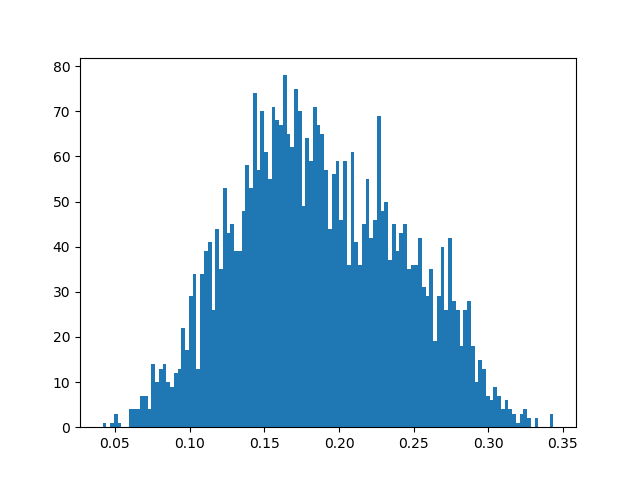

In [20]:
plt.hist(losses.numpy(), bins=120)
pass

In [25]:
idx = losses.argsort().numpy()
options = np.array(testset.tuples)

In [26]:
k = 100

In [27]:
print('top {}'.format(k))
for o in options[idx[:k]]:
    print('{:<15} {:<15} {:<15}'.format(*o))

top 100
green plants    provide         food           
tidal energy    produce         electricity    
animal          eat             food           
seed            storing food for plant          
chloroplast     contains        chlorophyll    
something changes color have            color          
electric devices require         energy         
animal          can survive in  environment    
burning wood    produce         heat           
alligators      eat             fish           
food            produce         energy         
respiration     use             energy         
herbivores      eat             plants         
energy          produce         electricity    
remora fish     eat             food           
fish            lives in        water          
plant           requires        sunlight       
plant           requires        sunlight       
battery         converts chemical energy into energy         
electrical energy produce         light          
temper

In [28]:
print('bottom {}'.format(k))
for o in options[idx[-k:]]:
    print('{:<15} {:<15} {:<15}'.format(*o))

bottom 100
system transfers oxygen to       system         
means           changing from   solid          
Appalachians    were            formed         
moon            rising          occurs per day 
sun             rising          causes cycles  
means           change from     whole          
available types is in           distant locations
stars           appear          move at night  
winter solstice is on           December 21st in northern hemisphere
bat births      live            young          
summer solstice is on           June 21st in northern hemisphere
planets         orbit           stars          
Matter          is in           gas phase      
Matter          is in           gas phase      
Earth           being           tilted         
Earth           being           tilted         
winter solstice is on           June 21st in southern hemisphere
most canyons    flowing rivers over periods of time
stars           are away from   very far Earth 
sifter         